# Download dataset

In [1]:
!gdown 1rRp1JPAh6AxnB8c02uVF7i4Hr0pO0sBx

Downloading...
From: https://drive.google.com/uc?id=1rRp1JPAh6AxnB8c02uVF7i4Hr0pO0sBx
To: /content/spr2023dpl301m.zip
100% 931M/931M [00:22<00:00, 40.6MB/s]


In [2]:
!unzip /content/spr2023dpl301m.zip
!rm /content/spr2023dpl301m.zip

Streaming output truncated to the last 5000 lines.
  inflating: devset_images/devset_images/4824229187.jpg  
  inflating: devset_images/devset_images/4824277270.jpg  
  inflating: devset_images/devset_images/4826227478.jpg  
  inflating: devset_images/devset_images/4826376634.jpg  
  inflating: devset_images/devset_images/4826792790.jpg  
  inflating: devset_images/devset_images/4826929093.jpg  
  inflating: devset_images/devset_images/4827390236.jpg  
  inflating: devset_images/devset_images/4827466697.jpg  
  inflating: devset_images/devset_images/4827604519.jpg  
  inflating: devset_images/devset_images/4828269380.jpg  
  inflating: devset_images/devset_images/482840358.jpg  
  inflating: devset_images/devset_images/4828718012.jpg  
  inflating: devset_images/devset_images/4831456559.jpg  
  inflating: devset_images/devset_images/4832569886.jpg  
  inflating: devset_images/devset_images/4832697096.jpg  
  inflating: devset_images/devset_images/4833441806.jpg  
  inflating: devset_im

# Packages

In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 49.4 MB/s eta 0:00:00


In [76]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import random
import os
import glob
import re
import json

from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.nn import Sequential
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Dataset
from torch import optim
import torchvision
import torchvision.transforms as T
from torchvision import models

import tensorflow as tf
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from collections import Counter

# Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

# Transformers
import transformers
from transformers import AutoModel, TFBertModel, TFRobertaModel, BertTokenizerFast, RobertaTokenizerFast
from transformers.models.bert.modeling_bert import BertModel, BertPreTrainedModel


# Metrics
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
device = torch.device("cuda:0")

# Feartures explore

As well as this dataset here aimed for a class competition is splitted into devset and testset, check what can we use of csv file in test phase

In [5]:
test_df = pd.read_csv('/content/test.csv')
test_df.columns

Index(['image_id', 'title', 'description', 'user_tags'], dtype='object')

So we have few features to use in classification such as image, title, description, user_tags

# Data Preprocessing

In [80]:
def clean_text(text):
    # remove urls
    text = re.sub(r'http\S+', " ", text)
    # remove mentions
    text = re.sub(r'@\w+',' ',text)
    # remove punctuations
    text = re.sub(r'[^\w\s]', '', text)
    # remove hastags
    text = re.sub(r'#\w+', ' ', text)
    # remove digits
    text = re.sub(r'\d+', ' ', text)
    # remove html tags
    text = re.sub('r<.*?>',' ', text)
    # remove stop words 
    text = text.split()
    text = " ".join([word for word in text if word not in stopwords])
    
    return text

In [7]:
# Collect dataset features
id = []
title = []
desc = []
tag = []

with open('/content/devset_images_metadata.json') as json_file:
    data = json.load(json_file)
    for p in data['images']:
      id.append(p['image_id'])
      title.append(p['title'])
      tag.append(' '.join([i.lower() for i in p['user_tags'] if not i.isdigit()]))
      desc.append(p['description'])


In [8]:
df = pd.DataFrame(np.array([id,title,desc,tag]).T,columns=['img_id','title','descrip','tag'])
df.img_id = df.img_id.astype(np.int64)

df = df.replace(r'^\s*$', np.nan, regex=True)
df = df.join(pd.read_csv('devset_images_gt.csv').set_index('id'),on='img_id')
df.head(n=5)

,img_id,title,descrip,tag,label
0,3519864665,Biltmore Estate,None,2009 road trip obrero road trip,0
1,4896119055,Chand Minar,None,daulatabad daulatabad fort ellora road trip,0
2,3468473862,Uplifting Graffiti,"After the flood, the boarded up stores bear up...",cedarrapids createsouthroadtrip2009 disaster g...,0
3,4120853942,DSCF6487,None,cork enchente flood ireland irlanda,0
4,4436083254,Oconoe river - flooded,None,athens georgia brown current flood mud river s...,0


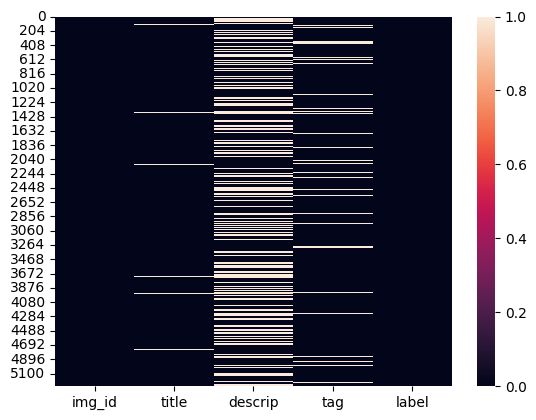

In [9]:
sns.heatmap(df.isnull());

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5280 entries, 0 to 5279
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   img_id   5280 non-null   int64 
 1   title    5188 non-null   object
 2   descrip  3344 non-null   object
 3   tag      4875 non-null   object
 4   label    5280 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 206.4+ KB


Any object type feature has null values, so just fill it with empty string

In [11]:
df = df.fillna(value='')
df['title'] = df['title'].astype('str')
df['descrip'] = df['descrip'].astype('str')
df['tag'] = df['tag'].astype('str')

# Split dataset

Because the description feature has largest number of null values, try add this feature into model then

In [12]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['title']+' '+df['tag'], df['label'], 
                                                                    random_state=2023, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2023, 
                                                                test_size=0.6, 
                                                                stratify=temp_labels)

# BERT with tf

In [58]:
MAX_LEN = 128

In [59]:
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data.iloc[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids,dtype=np.int32),np.array(attention_masks,dtype=np.int32)

In [60]:
train_input_ids, train_attention_masks = tokenize(train_text)
val_input_ids, val_attention_masks = tokenize(val_text)
test_input_ids, test_attention_masks = tokenize(test_text)

In [61]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [64]:
def create_model(bert_model, max_len=MAX_LEN):
    
    ##params###
    opt = tf.keras.optimizers.Adam(learning_rate=1e-6)
    loss = tf.keras.losses.BinaryCrossentropy()
    accuracy = tf.keras.metrics.Accuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    embeddings = bert_model([input_ids,attention_masks])[1]
    
    output = tf.keras.layers.Dense(1)(embeddings)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    
    model.compile(opt, loss=loss, metrics=accuracy)
    
    
    return model

In [65]:
model = create_model(bert_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [66]:
history_bert = model.fit([train_input_ids,train_attention_masks],
                         train_labels,
                         validation_data=([val_input_ids,val_attention_masks], val_labels),
                         epochs=4,
                         batch_size=32)

Epoch 1/4
116/116 [==============================] - 153s 853ms/step - loss: 5.6054 - accuracy: 0.0000e+00 - val_loss: 5.6046 - val_accuracy: 0.0000e+00
Epoch 2/4
116/116 [==============================] - 103s 891ms/step - loss: 5.6094 - accuracy: 0.0000e+00 - val_loss: 5.6046 - val_accuracy: 0.0000e+00
Epoch 3/4
116/116 [==============================] - 96s 825ms/step - loss: 5.6052 - accuracy: 0.0000e+00 - val_loss: 5.6046 - val_accuracy: 0.0000e+00
Epoch 4/4
116/116 [==============================] - 100s 864ms/step - loss: 5.6093 - accuracy: 0.0000e+00 - val_loss: 5.6046 - val_accuracy: 0.0000e+00


There must be an error here while accuracy and loss stay the same :D

In [67]:
result_bert = model.predict([test_input_ids,test_attention_masks])

30/30 [==============================] - 14s 277ms/step


In [68]:
y_pred_bert =  np.zeros_like(result_bert)

In [69]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

In [70]:
print('\tClassification Report for BERT:\n\n',classification_report(test_labels,y_pred_bert, target_names=['1', '0']))

	Classification Report for BERT:

               precision    recall  f1-score   support

           1       0.00      0.00      0.00       605
           0       0.36      1.00      0.53       346

    accuracy                           0.36       951
   macro avg       0.18      0.50      0.27       951
weighted avg       0.13      0.36      0.19       951



# BERT with torch

In [13]:
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<Axes: >

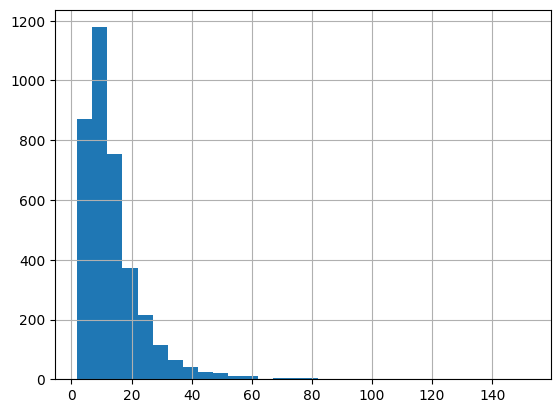

In [14]:
# get length of all the messages in the train set
seq_len = [len(i.split(' ')) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [15]:
max_seq_len = 36

In [16]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

In [17]:

# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [18]:
#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [19]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [33]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.15)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      # dense layer 2
      self.fc2=nn.Linear(512,1024)
      # dense layer 3 (Output layer)
      self.fc3 = nn.Linear(1024,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):


      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      x = self.fc1(cls_hs)
      x = self.relu(x)

      x = self.dropout(x)
      x = self.fc2(x)
      x = self.relu(x)

      x = self.dropout(x)
      # output layer
      x = self.fc3(x)
      x = self.dropout(x)
      # apply softmax activation
      x = self.softmax(x)

      return x

In [34]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)
     

In [35]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-6)

In [36]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', classes = np.unique(train_labels),y=train_labels)

print(class_wts)

[0.78571429 1.375     ]


In [37]:
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights,reduce = 'sum') 

# number of training epochs
epochs = 20

In [38]:
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds
     

In [39]:
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      #elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [40]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

In [41]:
#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
     


 Epoch 1 / 20
  Batch    50  of    116.
  Batch   100  of    116.

Evaluating...

Training Loss: 0.695
Validation Loss: 0.693

 Epoch 2 / 20
  Batch    50  of    116.
  Batch   100  of    116.

Evaluating...

Training Loss: 0.694
Validation Loss: 0.692

 Epoch 3 / 20
  Batch    50  of    116.
  Batch   100  of    116.

Evaluating...

Training Loss: 0.694
Validation Loss: 0.690

 Epoch 4 / 20
  Batch    50  of    116.
  Batch   100  of    116.

Evaluating...

Training Loss: 0.691
Validation Loss: 0.689

 Epoch 5 / 20
  Batch    50  of    116.
  Batch   100  of    116.

Evaluating...

Training Loss: 0.690
Validation Loss: 0.688

 Epoch 6 / 20
  Batch    50  of    116.
  Batch   100  of    116.

Evaluating...

Training Loss: 0.690
Validation Loss: 0.687

 Epoch 7 / 20
  Batch    50  of    116.
  Batch   100  of    116.

Evaluating...

Training Loss: 0.689
Validation Loss: 0.686

 Epoch 8 / 20
  Batch    50  of    116.
  Batch   100  of    116.

Evaluating...

Training Loss: 0.688
Validat

In [42]:
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

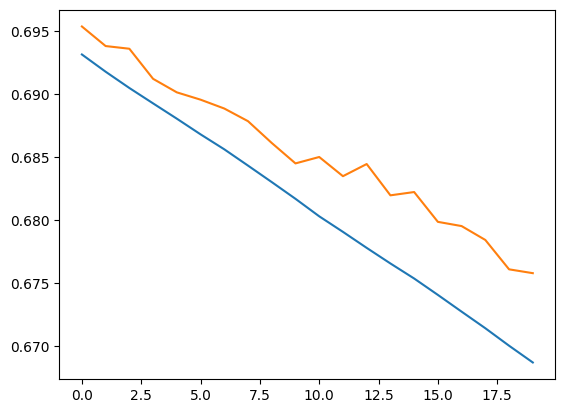

In [43]:
import matplotlib.pyplot as plt
plt.plot(valid_losses)
plt.plot(train_losses)
plt.show()

In [44]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.80      0.76      0.78       605
           1       0.61      0.66      0.64       346

    accuracy                           0.73       951
   macro avg       0.71      0.71      0.71       951
weighted avg       0.73      0.73      0.73       951



In [45]:
pd.crosstab(test_y, preds)
     

col_0,0,1
row_0,,
0,460,145
1,116,230


## Test model

In [46]:
test = pd.read_csv('test.csv')
test.head()

,image_id,title,description,user_tags
0,3483809003,"Flooded Parking Lot At Emily Fowler Library, A...",Denton Creek overflows its banks and floods Oa...,"project, slis 5715, spring 2009"
1,3712805295,L'arc de Barà / The roman arch of Barà,Sembla que fou dedicat a August entorn l'any 1...,"arc, arc_de_berà, arch, archaeology, arco, arq..."
2,379845620,Highest point over the sea level that is reach...,NaN,NaN
3,7343264988,Lagos after the rains,"After heavy rain, Lagos (Nigeria) was still fl...","africa, lagos, nigeria"
4,3843337492,flooded Corley Ave,also a local black out due to the tree branch ...,"flood, storm, toronto"


In [47]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_id     1320 non-null   int64 
 1   title        1299 non-null   object
 2   description  845 non-null    object
 3   user_tags    1210 non-null   object
dtypes: int64(1), object(3)
memory usage: 41.4+ KB


In [48]:
id = test.pop('image_id')
test = test.fillna(value='null')
test['title'] = test['title'].astype('str')
test['description'] = test['description'].astype('str')
test['user_tags'] = test['user_tags'].astype('str')
text = test['title']+'|'+test['user_tags']

In [49]:
result = tokenizer.batch_encode_plus(
    text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

In [50]:
test_seq = torch.tensor(result['input_ids'])
test_mask = torch.tensor(result['attention_mask'])
#test_y = torch.tensor(result.tolist())

In [51]:
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()
preds = np.argmax(preds, axis = 1)

In [52]:
result = pd.DataFrame(preds)
result.insert(loc=0,
          column='id',
          value=id)
result.columns = ['id','label']
result.to_csv('final.csv',index=False,)

# Text + Image

In [77]:
def get_train_transform():
    return T.Compose([
        T.RandomHorizontalFlip(p=0.25), # Random flip with probability = 0.5
        T.RandomRotation(18), # Random rotation with angle <= 15
        # T.ColorJitter(brightness=.5, hue=.3), # Bright contrast
        T.Resize((224, 224)),
        #T.RandomResizedCrop(224), # Random crop Image with shape 224
        T.ToTensor(),
        T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)), # Normalize according to ImageNet distribution
    ])
    
def get_val_transform():
    return T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ])   

In [78]:
import nltk
from nltk.corpus import stopwords
from spacy.lang.en.stop_words import STOP_WORDS
nltk.download('stopwords')
stop_words = stopwords.words('english')
stopwords = set(stop_words).union(STOP_WORDS)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [82]:
df_tag = []
for i in df['tag'].values:
  df_tag.append(clean_text(i))
df['tag'] = df_tag

df_title = []
for i in df['title'].values:
  df_title.append(clean_text(i))
df['title'] = df_title

df_descrip = []
for i in df['descrip'].values:
  df_descrip.append(clean_text(i))
df['descrip'] = df_descrip

In [83]:
train_path = '/content/devset_images/devset_images/'
test_path = '/content/testset_images/testset_images/'
def load_img(name ,mode ,transform):
  if mode != 'test':
    try:
      img = Image.open(train_path+str(name)+'.jpg')
    except:
      try:
        img = Image.open(train_path+str(name)+'.png')
      except:
        img = Image.open(train_path+str(name)+'.gif')
  else:
    try:
      img = Image.open(test_path+str(name)+'.jpg')
    except:
      img = Image.open(test_path+str(name)+'.png')
  img = transform(img)
  return img

In [84]:
max_seq_len = 128
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
title_token = tokenizer.batch_encode_plus(
    (df['title']+' '+df['descrip']).tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)
tag_token = tokenizer.batch_encode_plus(
    df['tag'].tolist(),
    max_length = max_seq_len//2,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

In [85]:
title_seq = torch.tensor(title_token['input_ids'])
title_mask = torch.tensor(title_token['attention_mask'])
tag_seq = torch.tensor(tag_token['input_ids'])
tag_mask = torch.tensor(tag_token['attention_mask'])

In [86]:
data = np.concatenate((df['img_id'].values.reshape(-1,1),title_seq,title_mask,tag_seq,tag_mask,df['label'].values.reshape(-1,1)),axis=1)

In [87]:
train, val = train_test_split(data,test_size = 0.20,random_state = 2023)

In [88]:
class MixDataset(Dataset):
  def __init__(self, ids,max_seq_len, transforms = None, mode ='train'):
        super().__init__()      
        self.transforms = transforms
        self.ids = ids
        self.mode = mode
  def __getitem__(self, idx):
      if self.mode == 'train' or self.mode == 'val':
          name = self.ids[idx][0]
          title = (self.ids[idx][1:max_seq_len+1],self.ids[idx][max_seq_len+1:2*max_seq_len+1])
          #tag = (self.ids[idx][2*max_seq_len+1:3*max_seq_len+1],self.ids[idx][3*max_seq_len+1:4*max_seq_len+1])
          tag = (self.ids[idx][2*max_seq_len+1:2*max_seq_len+max_seq_len//2+1],self.ids[idx][2*max_seq_len+max_seq_len//2+1:3*max_seq_len+1])
          img = load_img(name, mode = self.mode,transform = self.transforms)
          label = self.ids[idx][-1]

          return img,title,tag, label
      elif self.mode == 'test':
          name = self.ids[idx][0]
          title = (self.ids[idx][1:max_seq_len+1],self.ids[idx][max_seq_len+1:2*max_seq_len+1])
          #tag = (self.ids[idx][2*max_seq_len+1:3*max_seq_len+1],self.ids[idx][3*max_seq_len+1:4*max_seq_len+1])
          tag = (self.ids[idx][2*max_seq_len+1:2*max_seq_len+max_seq_len//2+1],self.ids[idx][2*max_seq_len+max_seq_len//2+1:3*max_seq_len+1])
          img = load_img(name, mode = self.mode,transform = self.transforms)
          return img,title,tag,name
  def __len__(self):
        return len(self.ids)

In [89]:
train_set = MixDataset(train,max_seq_len,get_train_transform(),mode = 'train')
val_set = MixDataset(val,max_seq_len,get_val_transform(),mode = 'val')

In [90]:
train_data_loader = DataLoader(
    dataset = train_set,
    num_workers = 2,
    batch_size = 32,
    shuffle = True
)
val_data_loader = DataLoader(
    dataset = val_set,
    num_workers = 2,
    batch_size = 8,
    shuffle = True
)

In [91]:
class MulBert(nn.Module):
  def __init__(self):
        super(MulBert, self).__init__()
        self.Bert_1 = BertModel.from_pretrained('bert-base-uncased')
        self.Bert_2 = BertModel.from_pretrained('bert-base-uncased')

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(768*2, 1000),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(1000, 724),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(724, 300),
        )

  def forward(self, sent_id_1, mask_1, sent_id_2 ,mask_2):  
        sent_id_1 = sent_id_1.squeeze(0)
        sent_id_2 = sent_id_2.squeeze(0)

        _ , outputs_1 = self.Bert_1(sent_id_1,attention_mask=mask_1, return_dict=False)
        _ , outputs_2 = self.Bert_2(sent_id_2,attention_mask=mask_2, return_dict=False)

        outputs = torch.cat((outputs_1,outputs_2),1)
        outputs =  self.linear_relu_stack(outputs) # add hidden states and attention if they are here

        return outputs

In [92]:
class Dirsm(nn.Module):
  def __init__(self):
        super(Dirsm, self).__init__()
        self.visual = models.wide_resnet50_2(weights='IMAGENET1K_V2')
        self.visual.fc = nn.Sequential(nn.Linear(in_features = 2048,out_features = 1000))
        self.text = MulBert()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=1300,out_features=1000),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(in_features=1000,out_features = 512),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(in_features=512,out_features = 256),
            nn.Dropout(0.15),
            nn.ReLU(),
            nn.Linear(in_features=256,out_features = 1),
            nn.Dropout(0.1),
            nn.Sigmoid()
        )
  def forward(self,
        sent_id_1, mask_1,
        sent_id_2 ,mask_2,image):
        out1 = self.visual(image)
        out2 = self.text(sent_id_1, mask_1,
        sent_id_2 ,mask_2)
        out = torch.cat((out1,out2),1)
        out = self.classifier(out)
        return out

In [93]:
def accuracy(preds,trues):
  preds = [1 if preds[i] >= 0.5 else 0 for i in range(len(preds))]
  acc = [[1 if preds[i] == trues[i] else 0 for i in range(len(preds))]]
  acc = np.sum(acc)/len(preds)
  return acc*100

In [94]:
import time
def train_one_epoch(train_data_loader,model,optimizer):
  epoch_loss = []
  epoch_acc =[]
  model.train()
  start_time = time.time()

  for images,title,tag,labels in tqdm(train_data_loader):
    images = images.to(device)

    sent_id_1, mask_1 = title

    sent_id_1 = sent_id_1.to(device)
    mask_1 = mask_1.to(device)

    sent_id_2, mask_2 = tag
    sent_id_2 = sent_id_2.to(device)
    mask_2 = mask_2.to(device)

    labels = labels.to(device)
    labels = labels.reshape((labels.shape[0],1)).to(torch.float32)

    

    optimizer.zero_grad()

    preds = model(sent_id_1, mask_1,sent_id_2, mask_2,images)
    preds = preds.to(torch.float32)
    _loss = criterion(preds,labels)
    loss = _loss.item()
    epoch_loss.append(loss)

    acc = accuracy(preds,labels)
    epoch_acc.append(acc)
    _loss.backward()
    optimizer.step()
  
  end_time = time.time()

  epoch_loss =np.mean(epoch_loss)
  epoch_acc = np.mean(epoch_acc)
  total_time = end_time - start_time

  train_logs['loss'] = epoch_loss
  train_logs['acc'] = epoch_acc
  train_logs['time'] = total_time
  return epoch_loss,epoch_acc,total_time

In [95]:
save_path = '/content/'
def val_one_epoch(val_data_loader,model,min_epoch,model_name):
  epoch_loss = []
  epoch_acc = []
  start_time = time.time()

  model.eval()

  for images, title, tag, labels in tqdm(val_data_loader):
    images = images.to(device)

    sent_id_1, mask_1 = title

    sent_id_1 = sent_id_1.to(device)
    mask_1 = mask_1.to(device)

    sent_id_2, mask_2 = tag
    sent_id_2 = sent_id_2.to(device)
    mask_2 = mask_2.to(device)

    labels = labels.to(device)
    labels = labels.reshape((labels.shape[0],1)).to(torch.float32)

    preds = model(sent_id_1, mask_1,sent_id_2, mask_2,images)
    preds = preds.to(torch.float32)
    _loss = criterion(preds,labels)
    
    loss = _loss.item()
    epoch_loss.append(loss)

    acc = accuracy(preds,labels)
    epoch_acc.append(acc)

  end_time = time.time()
  total_time = end_time - start_time
  epoch_loss = np.mean(epoch_loss)
  epoch_acc = np.mean(epoch_acc)
  val_logs['loss'] = epoch_loss
  val_logs['acc'] = epoch_acc
  val_logs['time'] = total_time
  if(epoch_loss < min_epoch):
      min_epoch = epoch_loss
      torch.save(model.state_dict(),save_path+model_name+"best.pth")
  return epoch_loss, epoch_acc, total_time, min_epoch

In [96]:
model = Dirsm()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_

In [ ]:
model.zero_grad()
optimizer = optim.Adam(model.parameters(),lr=1e-4)

lr_scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=15,gamma=0.5)

criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()
train_logs = {'loss':[],'acc':[],'time':[]}
val_logs = {'loss':[],'acc':[],'time':[]}

model.to(device)

In [98]:
epochs = 2

In [99]:
best_val_acc=1e6

In [100]:

for epoch in range(epochs):
  print("\nTraining")
  print("Epoch ",(epoch+1))
  loss,acc,_time = train_one_epoch(train_data_loader,model,optimizer)
  print("Loss: ",round(loss,4))
  print("Accuracy: ",round(acc,2))
  print("Time: ",round(_time,4))
  loss,acc,_time,best_val_acc = val_one_epoch(val_data_loader,model,best_val_acc,'best_fusion_freeze_new_30')
  print("\nValidation")
  print("Epoch ",(epoch+1))
  print("Loss: ",round(loss,4))
  print("Accuracy: ",round(acc,2))
  print("Time: ",round(_time,4))


Training
Epoch  1


100%|██████████| 132/132 [03:29<00:00,  1.59s/it]


Loss:  0.3733
Accuracy:  79.12
Time:  209.4216


100%|██████████| 132/132 [00:20<00:00,  6.35it/s]



Validation
Epoch  1
Loss:  0.1981
Accuracy:  92.33
Time:  20.7919

Training
Epoch  2


100%|██████████| 132/132 [03:30<00:00,  1.60s/it]


Loss:  0.2127
Accuracy:  88.52
Time:  210.7867


100%|██████████| 132/132 [00:20<00:00,  6.36it/s]



Validation
Epoch  2
Loss:  0.1949
Accuracy:  92.05
Time:  20.7871
